In [67]:
import pandas as pd

# Load the Excel file
file_path = '/mnt/data/Book1.xlsx'
data = pd.read_excel('Book1.xlsx')

# Display the first few rows and the columns of the dataset
data.head(), data.columns


(   State  LGA                    Ward                   PU-Name  Latitude  \
 0  KWARA  ASA           YOWERE/SOSOKI        SOSOKI L G E A SCH  8.966896   
 1  KWARA  ASA  ADIGBONGBO/AWE/ORIMARO    ADIGBONGBO L.G.E.A SCH  8.544337   
 2  KWARA  ASA  ADIGBONGBO/AWE/ORIMARO           AWE L.G.E.A SCH  8.535932   
 3  KWARA  ASA  ADIGBONGBO/AWE/ORIMARO       AFO-OJA L.G.E.A SCH  8.535201   
 4  KWARA  ASA  ADIGBONGBO/AWE/ORIMARO  YEDE/ORIMARO L.G.E.A SCH  8.535932   
 
    Longitude   APC  LP  PDP  NNPP  
 0   4.387405  1500   0    8     2  
 1   4.434528     0   0    0     0  
 2   4.428498     0   0    0     0  
 3   4.356674     0   0    0     0  
 4   4.428498     0   0    0     0  ,
 Index(['State', 'LGA', 'Ward', 'PU-Name', 'Latitude', 'Longitude', 'APC', 'LP',
        'PDP', 'NNPP'],
       dtype='object'))

In [68]:
from sklearn.neighbors import BallTree
import numpy as np

# Extract the latitude and longitude values
coordinates = data[['Latitude', 'Longitude']].values

# Create a BallTree for fast spatial queries
tree = BallTree(np.radians(coordinates), metric='haversine')

# Query for the 10 nearest neighbors (including the polling unit itself)
distances, indices = tree.query(np.radians(coordinates), k=10)

# Convert distances from radians to kilometers (Earth radius = 6371 km)
distances = distances * 6371

# Show the indices and distances of the nearest neighbors for the first few polling units
neighbors_info = pd.DataFrame({
    'Polling Unit': data['PU-Name'],
    'Neighbors Indices': [indices[i].tolist() for i in range(len(indices))],
    'Distances (km)': [distances[i].tolist() for i in range(len(distances))]
})

neighbors_info.head()


,Polling Unit,Neighbors Indices,Distances (km)
0,SOSOKI L G E A SCH,"[0, 216, 170, 11, 196, 192, 193, 299, 240, 6]","[0.0, 0.0, 0.0, 0.0, 9.472751415455987, 26.033..."
1,ADIGBONGBO L.G.E.A SCH,"[1, 2, 4, 235, 5, 144, 145, 143, 240, 3]","[0.0, 1.1459115064964946, 1.1459115064964946, ..."
2,AWE L.G.E.A SCH,"[2, 235, 4, 1, 5, 3, 143, 144, 145, 240]","[0.0, 0.0, 0.0, 1.1459115064964946, 5.41863318..."
3,AFO-OJA L.G.E.A SCH,"[3, 5, 238, 2, 235, 4, 1, 6, 240, 239]","[0.0, 2.8084271974310817, 4.070019861026185, 7..."
4,YEDE/ORIMARO L.G.E.A SCH,"[2, 235, 4, 1, 5, 3, 143, 144, 145, 240]","[0.0, 0.0, 0.0, 1.1459115064964946, 5.41863318..."


In [69]:
from scipy.stats import zscore

# Initialize columns for outlier scores
parties = ['APC', 'LP', 'PDP', 'NNPP']
for party in parties:
    data[f'{party}_Outlier_Score'] = 0.0

# Calculate the outlier scores
for i in range(len(data)):
    neighbor_indices = indices[i]
    for party in parties:
        neighbor_votes = data.loc[neighbor_indices, party]
        mean_votes = neighbor_votes.mean()
        std_votes = neighbor_votes.std()
        
        if std_votes > 0:
            z_score = (data.at[i, party] - mean_votes) / std_votes
        else:
            z_score = 0.0  # Handle cases where all neighboring votes are the same
            
        data.at[i, f'{party}_Outlier_Score'] = z_score

# Show the first few rows of the dataframe with outlier scores
data.head()


,State,LGA,Ward,PU-Name,Latitude,Longitude,APC,LP,PDP,NNPP,APC_Outlier_Score,LP_Outlier_Score,PDP_Outlier_Score,NNPP_Outlier_Score
0,KWARA,ASA,YOWERE/SOSOKI,SOSOKI L G E A SCH,8.966896,4.387405,1500,0,8,2,2.816760,-0.372837,-0.433915,2.84605
1,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,ADIGBONGBO L.G.E.A SCH,8.544337,4.434528,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000
2,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AWE L.G.E.A SCH,8.535932,4.428498,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000
3,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AFO-OJA L.G.E.A SCH,8.535201,4.356674,0,0,0,0,-0.463584,0.000000,-0.450309,0.00000
4,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,YEDE/ORIMARO L.G.E.A SCH,8.535932,4.428498,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000


In [70]:
from scipy.stats import zscore

# Initialize columns for outlier scores
parties = ['APC', 'LP', 'PDP', 'NNPP']
for party in parties:
    data[f'{party}_Outlier_Score'] = 0.0

# Calculate the outlier scores
for i in range(len(data)):
    neighbor_indices = indices[i]
    for party in parties:
        neighbor_votes = data.loc[neighbor_indices, party]
        mean_votes = neighbor_votes.mean()
        std_votes = neighbor_votes.std()
        
        if std_votes > 0:
            z_score = (data.at[i, party] - mean_votes) / std_votes
        else:
            z_score = 0.0  # Handle cases where all neighboring votes are the same
            
        data.at[i, f'{party}_Outlier_Score'] = z_score

# Show the first few rows of the dataframe with outlier scores
data.head()


,State,LGA,Ward,PU-Name,Latitude,Longitude,APC,LP,PDP,NNPP,APC_Outlier_Score,LP_Outlier_Score,PDP_Outlier_Score,NNPP_Outlier_Score
0,KWARA,ASA,YOWERE/SOSOKI,SOSOKI L G E A SCH,8.966896,4.387405,1500,0,8,2,2.816760,-0.372837,-0.433915,2.84605
1,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,ADIGBONGBO L.G.E.A SCH,8.544337,4.434528,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000
2,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AWE L.G.E.A SCH,8.535932,4.428498,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000
3,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AFO-OJA L.G.E.A SCH,8.535201,4.356674,0,0,0,0,-0.463584,0.000000,-0.450309,0.00000
4,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,YEDE/ORIMARO L.G.E.A SCH,8.535932,4.428498,0,0,0,0,-0.316228,0.000000,-0.316228,0.00000


In [71]:
# Sort the dataset by outlier scores for each party
sorted_data_apc = data.sort_values(by='APC_Outlier_Score', ascending=False).head(3)
sorted_data_lp = data.sort_values(by='LP_Outlier_Score', ascending=False).head(3)
sorted_data_pdp = data.sort_values(by='PDP_Outlier_Score', ascending=False).head(3)
sorted_data_nnpp = data.sort_values(by='NNPP_Outlier_Score', ascending=False).head(3)

# Highlight the top 3 outliers for each party and their closest polling units
top_outliers = pd.concat([sorted_data_apc, sorted_data_lp, sorted_data_pdp, sorted_data_nnpp])

# Fetch the closest neighbors for these top outliers
top_outliers_neighbors = []
for i in top_outliers.index:
    neighbor_indices = indices[i][:4]  # Get the closest 3 neighbors (excluding itself)
    neighbors = data.loc[neighbor_indices, ['PU-Name', 'APC', 'LP', 'PDP', 'NNPP']]
    top_outliers_neighbors.append(neighbors)

top_outliers, top_outliers_neighbors


(     State          LGA                    Ward  \
 63   KWARA     IFELODUN                     ORA   
 240  KWARA          ASA           YOWERE/SOSOKI   
 221  KWARA       PATIGI              PATIGI 111   
 63   KWARA     IFELODUN                     ORA   
 221  KWARA       PATIGI              PATIGI 111   
 84   KWARA  ILORIN EAST  AGBEYANGI/GBADAMU/OSIN   
 240  KWARA          ASA           YOWERE/SOSOKI   
 169  KWARA         ISIN                    ALLA   
 221  KWARA       PATIGI              PATIGI 111   
 323  KWARA       PATIGI                PATIGI 1   
 0    KWARA          ASA           YOWERE/SOSOKI   
 205  KWARA         OFFA                ESSA - C   
 
                                PU-Name  Latitude  Longitude   APC    LP  PDP  \
 63              OPEN SPACE ARAROMI OKE  8.439995   4.969996    26     3    7   
 240             LGEA SCH IYANA ALAKUKO  8.620677   4.431554    52     0   63   
 221                       TSADU'S GATE  8.721124   5.756315    90    16   37  

In [72]:
# Calculate the absolute difference in votes for each party compared to the votes of its neighboring units
for party in parties:
    data[f'{party}_Difference'] = 0.0

# Calculate the absolute differences and new outlier scores
for i in range(len(data)):
    neighbor_indices = indices[i]
    for party in parties:
        neighbor_votes = data.loc[neighbor_indices, party]
        mean_votes = neighbor_votes.mean()
        abs_diff = abs(data.at[i, party] - mean_votes)
        data.at[i, f'{party}_Difference'] = abs_diff

# Calculate the new outlier score as the absolute difference
for party in parties:
    data[f'{party}_Outlier_Score_Absolute'] = data[f'{party}_Difference']

# Show the first few rows of the dataframe with the new outlier scores
data.head()


,State,LGA,Ward,PU-Name,Latitude,Longitude,APC,LP,PDP,NNPP,...,PDP_Outlier_Score,NNPP_Outlier_Score,APC_Difference,LP_Difference,PDP_Difference,NNPP_Difference,APC_Outlier_Score_Absolute,LP_Outlier_Score_Absolute,PDP_Outlier_Score_Absolute,NNPP_Outlier_Score_Absolute
0,KWARA,ASA,YOWERE/SOSOKI,SOSOKI L G E A SCH,8.966896,4.387405,1500,0,8,2,...,-0.433915,2.84605,1311.1,2.8,15.4,1.8,1311.1,2.8,15.4,1.8
1,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,ADIGBONGBO L.G.E.A SCH,8.544337,4.434528,0,0,0,0,...,-0.316228,0.00000,5.2,0.0,6.3,0.0,5.2,0.0,6.3,0.0
2,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AWE L.G.E.A SCH,8.535932,4.428498,0,0,0,0,...,-0.316228,0.00000,5.2,0.0,6.3,0.0,5.2,0.0,6.3,0.0
3,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,AFO-OJA L.G.E.A SCH,8.535201,4.356674,0,0,0,0,...,-0.450309,0.00000,12.9,0.0,17.9,0.0,12.9,0.0,17.9,0.0
4,KWARA,ASA,ADIGBONGBO/AWE/ORIMARO,YEDE/ORIMARO L.G.E.A SCH,8.535932,4.428498,0,0,0,0,...,-0.316228,0.00000,5.2,0.0,6.3,0.0,5.2,0.0,6.3,0.0


In [36]:
!pip install matplotlib geopandas shapely


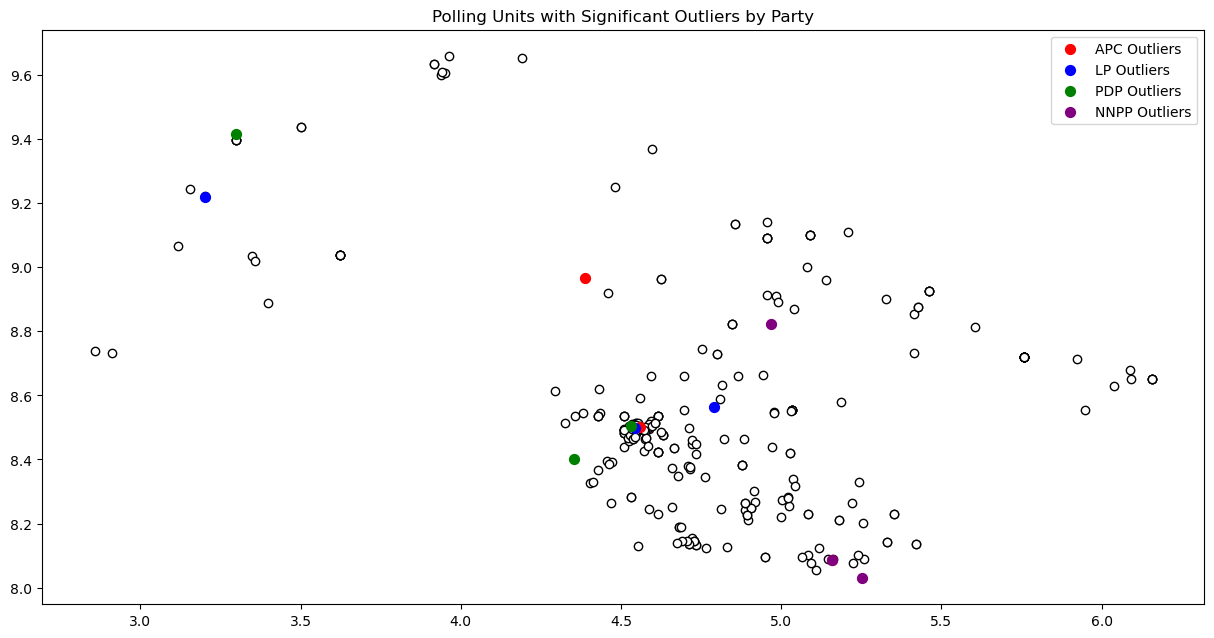

In [73]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Define the save directory
save_directory = '/mnt/data/'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Create a GeoDataFrame from the polling unit data
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry)

# Set up the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
base = geo_df.plot(ax=ax, color='white', edgecolor='black')

# Plot APC outliers
apc_outliers = geo_df.nlargest(3, 'APC_Outlier_Score_Absolute')
apc_outliers.plot(ax=base, marker='o', color='red', markersize=50, label='APC Outliers')

# Plot LP outliers
lp_outliers = geo_df.nlargest(3, 'LP_Outlier_Score_Absolute')
lp_outliers.plot(ax=base, marker='o', color='blue', markersize=50, label='LP Outliers')

# Plot PDP outliers
pdp_outliers = geo_df.nlargest(3, 'PDP_Outlier_Score_Absolute')
pdp_outliers.plot(ax=base, marker='o', color='green', markersize=50, label='PDP Outliers')

# Plot NNPP outliers
nnpp_outliers = geo_df.nlargest(3, 'NNPP_Outlier_Score_Absolute')
nnpp_outliers.plot(ax=base, marker='o', color='purple', markersize=50, label='NNPP Outliers')

# Set plot title and legend
plt.title('Polling Units with Significant Outliers by Party')
plt.legend()

# Save the plot
plt.savefig(os.path.join(save_directory, 'PU-Name_outliers_map.png'))

plt.show()


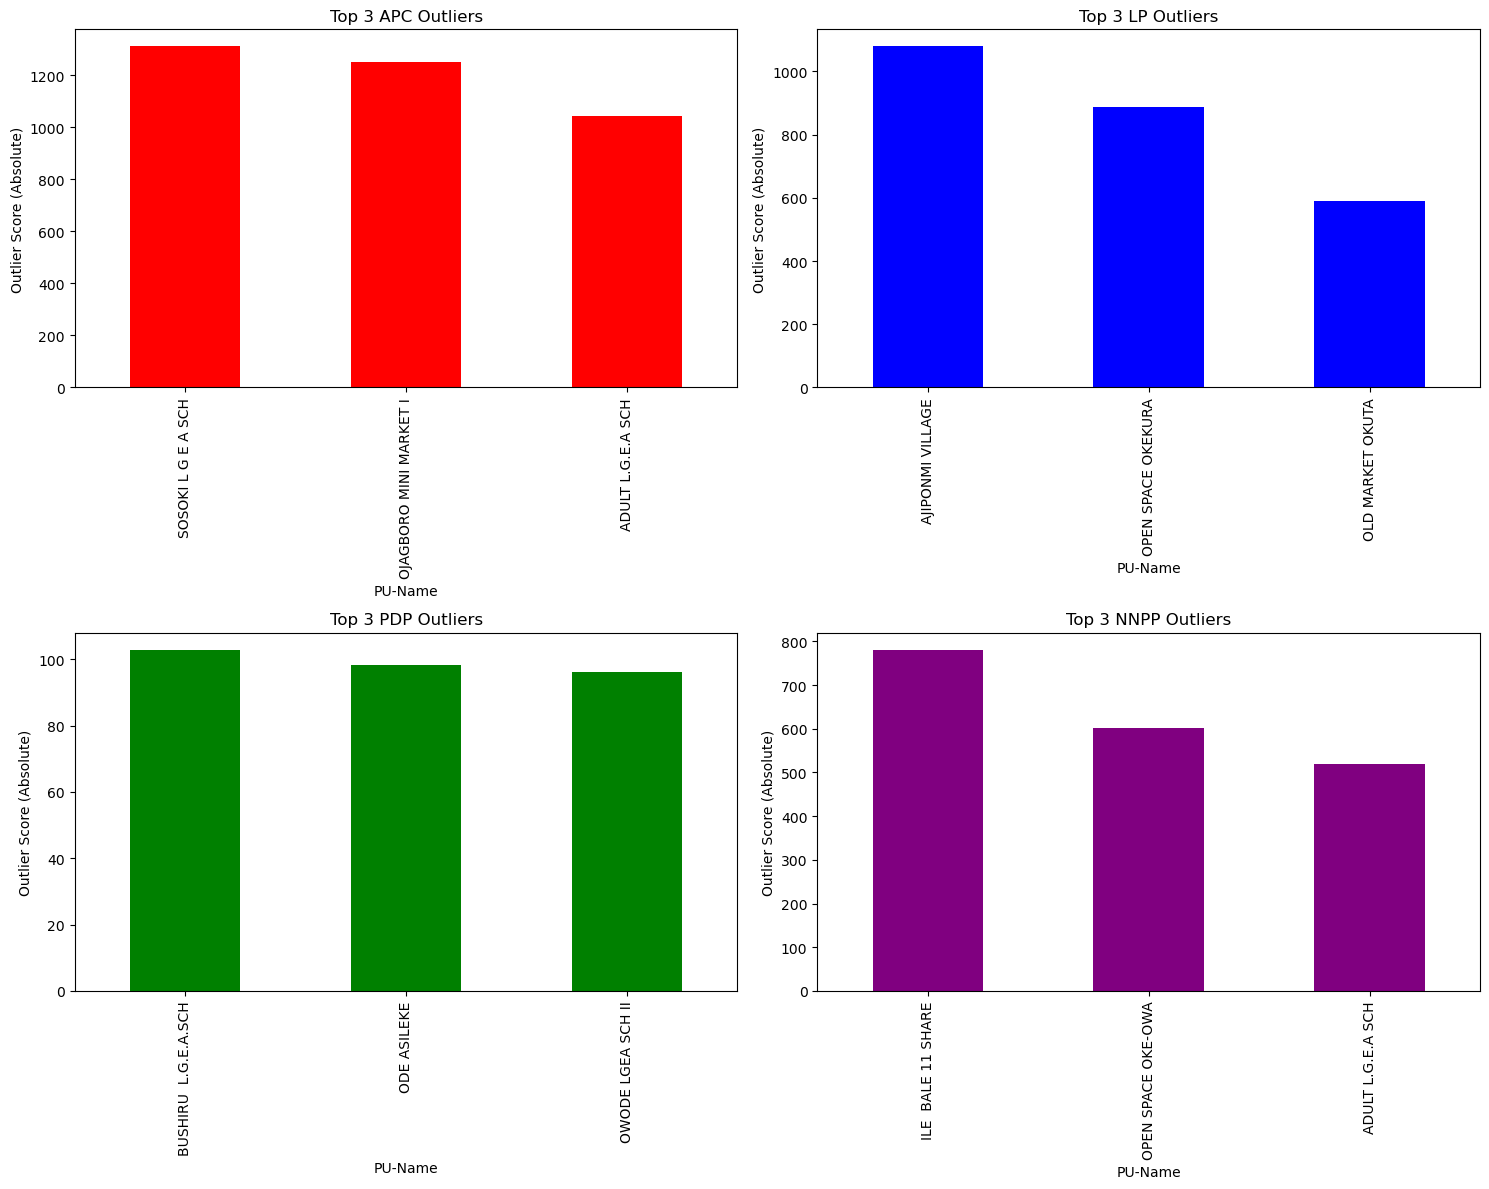

In [74]:
# Create bar charts for the outlier scores of the top 3 outliers in each party
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Define the save directory
save_directory = '/mnt/data/'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    
# APC outliers
apc_outliers = apc_outliers[['PU-Name', 'APC_Outlier_Score_Absolute']].set_index('PU-Name')
apc_outliers.plot(kind='bar', ax=axes[0, 0], color='red', legend=False)
axes[0, 0].set_title('Top 3 APC Outliers')
axes[0, 0].set_ylabel('Outlier Score (Absolute)')

# LP outliers
lp_outliers = lp_outliers[['PU-Name', 'LP_Outlier_Score_Absolute']].set_index('PU-Name')
lp_outliers.plot(kind='bar', ax=axes[0, 1], color='blue', legend=False)
axes[0, 1].set_title('Top 3 LP Outliers')
axes[0, 1].set_ylabel('Outlier Score (Absolute)')

# PDP outliers
pdp_outliers = pdp_outliers[['PU-Name', 'PDP_Outlier_Score_Absolute']].set_index('PU-Name')
pdp_outliers.plot(kind='bar', ax=axes[1, 0], color='green', legend=False)
axes[1, 0].set_title('Top 3 PDP Outliers')
axes[1, 0].set_ylabel('Outlier Score (Absolute)')

# NNPP outliers
nnpp_outliers = nnpp_outliers[['PU-Name', 'NNPP_Outlier_Score_Absolute']].set_index('PU-Name')
nnpp_outliers.plot(kind='bar', ax=axes[1, 1], color='purple', legend=False)
axes[1, 1].set_title('Top 3 NNPP Outliers')
axes[1, 1].set_ylabel('Outlier Score (Absolute)')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(os.path.join(save_directory, 'top_outliers_by_party.png'))

plt.show()


In [56]:
# Save the plot as an image file (e.g., PNG)
plt.savefig('plot.png')

<Figure size 640x480 with 0 Axes>

In [43]:
import pandas as pd
import os

# Path to the Downloads folder
downloads_folder = os.path.expanduser("~/Downloads")  # Corrected typo in 'expanduser'

# Name of the Excel file to be saved
excel_file_name = 'data.xlsx'  # Change this to the desired file name

# Full path to save the Excel file
file_path = os.path.join(downloads_folder, excel_file_name)  # Corrected variable name

# Save the DataFrame to an Excel file
data.to_excel(file_path, index=False)  # Corrected typo in 'index'

print(f"Dataframe saved as {file_path}")  # Corrected formatting for print statement
# Save the DataFrame to an Excel file
data.to_excel(file_path, index=False)  # Corrected typo in 'index'



Dataframe saved as C:\Users\Admin/Downloads\data.xlsx
